# Required Imports

In [5]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cycler


from scipy import stats

plt.rcParams['text.usetex'] = True

# Wi-Fi Signals Processing

## Build CSI matrices from RAW data

In [6]:
# Build CSI matrices (one per packet) from the RAW CSV file
def csv2csimatrix(file_path):
    # Read the file
    df = pd.read_csv(file_path, header=None)

    # Split the data in each row
    split_data = df[0].str.split(';', expand=True)

    # Convert to numeric values for real and imaginary parts
    raw_data = split_data.iloc[:, :-2].astype(float)

    # Combine real and imaginary parts into complex numbers
    complex_cols = [raw_data.iloc[:, i] + 1j * raw_data.iloc[:, i + 1] for i in range(0, raw_data.shape[1] - 1, 2)]

    # Create a new CSI matrix for complex numbers
    csi_matrix = pd.DataFrame(complex_cols).transpose()

    # Drop the specified columns (i.e., subcarriers at 0)
    columns_to_drop = [0, 1, 2, 3, 4, 5, 32, 59, 60, 61, 62, 63]
    csi_matrix.drop(csi_matrix.columns[columns_to_drop], axis=1, inplace=True)

    # Compute the remaining number of subcarriers
    n_subcarriers = csi_matrix.shape[1]

    # Add the timestamp column (second-last column of the original data)
    csi_matrix['timestamp'] = split_data.iloc[:, -2]

    # Compute the total number of packets
    n_packets = csi_matrix.shape[0]

    return csi_matrix, n_subcarriers

In [7]:
# Define file ID
def extract_id_from_filename(filename):
    """ Extract the ID from the filename, including the number and the trailing 'A' or 'B'. """
    #match = re.search(r'_(\d+)[mf]?([AB])\.', filename) # e.g., 00001A
    #return f"{match.group(1)}{match.group(2)}" if match else None
    match = re.search(r'_(\d+[mf][AB])\.', filename) # e.g., 00001mA
    return match.group(1) if match else None

# Build and save the CSI matrices to dictionary and CSV file
def process_and_save_files(directory, output_folder):
    # Dictionary to collect all CSI matrices ('ID[mf][AB]': CSI matrices)
    csi_collection = {}

    # Folder to save the processed files
    output_path = os.path.join(output_folder,'CSV','csi_matrices')
    if not os.path.exists(output_path):
      os.makedirs(output_path)

    for file_name in os.listdir(directory):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory, file_name)

            # Process the file, compute the CSI matrix, determine the remaining number of subcarriers, determine the total number of packets
            processed_csi, n_subcarriers = csv2csimatrix(file_path)
            #print(processed_df)

            # Extract ID from the file name
            file_id = extract_id_from_filename(file_name)
            if file_id:
                # Collect CSI matrices per ID[mf][AB] and store them in a dictionary
                csi_collection[file_id] = processed_csi

            # Construct the output file name: ID[mf][AB]
            new_file_name = f"{file_id}.csv"

            # Save the CSI matrices to CSV file
            processed_csi.to_csv(os.path.join(output_path, new_file_name), index=False)
            #print(f"Processed and saved: {output_path}")

    return csi_collection, n_subcarriers

# Directory containing the CSV files to process
input_directory = './data/'

# Folder to save the processed files
output_folder = './output/'
if not os.path.exists(output_folder):
  os.mkdir(output_folder)

# Process and save the files
csi_collection, n_subcarriers = process_and_save_files(input_directory, output_folder)

## Compute Amplitude values from CSI matrices

### Raw Amplitude values

In [8]:
def compute_amplitude(csi_matrices):
    """Compute the amplitude of complex numbers in a CSI matrix."""
    # Apply the amplitude calculation to each CSI matrix
    return csi_matrices.applymap(lambda csi: np.abs(csi) if isinstance(csi, complex) else csi) # the 'timestamp' column is ignored

# Compute the amplitude for all CSI matrices for each ID[A/B]
amplitudes = {ID: compute_amplitude(csi_matrices) for ID, csi_matrices in csi_collection.items()}

# Folder to save the sanitized amplitudes to file
output_path = os.path.join(output_folder,'CSV','raw_amplitudes')
if not os.path.exists(output_path):
  os.makedirs(output_path)

# Folder to save the sanitized amplitudes to file
for key, _ in amplitudes.items():
  # Construct the output file name: ID[mf][AB]
  new_file_name = f"{key}.csv"
  # Save the amplitudes to CSV file per ID[A/B]
  amplitudes[key].to_csv(os.path.join(output_path, new_file_name), index=False)
  
'''
# Plotting the Magnitude of WiFi Signal (Example)
ID = '00001mA'
plt.figure(figsize=(12, 6))
plt.imshow(amplitudes[ID].drop(columns='timestamp').applymap(float).T, aspect='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Packets')
plt.ylabel('Subcarriers')
plt.title(f'Relationship between Packets and Subcarriers - ID: {ID}')
plt.show()

# Plotting the Amplitude of WiFi Signal (Example)
plt.figure(figsize=(12, 6))
# Using a colormap to get a unique color for each subcarrier
colors = plt.cm.viridis(np.linspace(0, 1, len(amplitudes[ID].values)))
# Plotting each subcarrier's amplitude across packets with a unique color
for packet in range(len(amplitudes[ID].values)):
    plt.plot(np.arange(len(amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}', color=colors[packet])
plt.xlabel('Subcarriers')
plt.ylabel('Amplitude')
plt.title(f'Amplitude of Packets across Subcarriers - ID: {ID}')
plt.show()
'''

C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\3333859949.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return csi_matrices.applymap(lambda csi: np.abs(csi) if isinstance(csi, complex) else csi) # the 'timestamp' column is ignored


"\n# Plotting the Magnitude of WiFi Signal (Example)\nID = '00001mA'\nplt.figure(figsize=(12, 6))\nplt.imshow(amplitudes[ID].drop(columns='timestamp').applymap(float).T, aspect='auto')\nplt.colorbar(label='Magnitude')\nplt.xlabel('Packets')\nplt.ylabel('Subcarriers')\nplt.title(f'Relationship between Packets and Subcarriers - ID: {ID}')\nplt.show()\n\n# Plotting the Amplitude of WiFi Signal (Example)\nplt.figure(figsize=(12, 6))\n# Using a colormap to get a unique color for each subcarrier\ncolors = plt.cm.viridis(np.linspace(0, 1, len(amplitudes[ID].values)))\n# Plotting each subcarrier's amplitude across packets with a unique color\nfor packet in range(len(amplitudes[ID].values)):\n    plt.plot(np.arange(len(amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}', color=colors[packet])\nplt.xlabel('Subcarriers')\nplt.ylabel('Amplitude')\nplt.title(f'Amplitude of 

### Sanitize Amplitue values (Hampel filter)

In [ ]:
def sanitize_amplitude_hampel(amplitude_values, window_size, xi):
    """Sanitize amplitude using the Hampel identifier."""

    # Save timestamps for later recovery
    timestamps = amplitude_values.iloc[:, -1]
    # Temporarily removing the 'timestamp' column for computation
    amplitude_values = amplitude_values.drop(columns='timestamp')

    def hampel_filter(column):
      # Calculate the local median and MAD within the sliding window
      rolling_median = column.rolling(window=window_size, center=True).median()
      mad = lambda x: np.median(np.abs(x - np.median(x)))
      rolling_mad = column.rolling(window=window_size, center=True).apply(mad, raw=True)

      """If the first few values in a column (subcarrier) are NaNs or identified as outliers, there won't be any previous non-outlier value to fill forward.
      This situation can lead to the presence of NaN values in the sanitized data.
      Possible solution: after applying the forward fill, you can also apply a backward fill to handle cases where the first values are NaNs.
      This way, if there are NaNs at the start of the series, they will be filled with the next available non-outlier value."""

      # Identify outliers
      outliers = np.abs(column - rolling_median) > xi * rolling_mad
      # Replace outliers with NaN
      column[outliers] = np.nan
      # Forward-fill the NaN values with the previous non-outlier number
      column.fillna(method='ffill', inplace=True)
      # Backward-fill if the first values are still NaN
      column.fillna(method='bfill', inplace=True)

      return column

    # Applaying Hampel Filter to all subcarriers (columns)
    amplitude_values.apply(hampel_filter, axis=0)

    # Recovering timestamp column
    amplitude_values['timestamp'] = timestamps

    return amplitude_values

# Defining parameters for outliers detection
window_size = 50
xi = 3

# Apply amplitude sanitization function to each ID[mf][AB]
hampel_amplitudes = {ID: sanitize_amplitude_hampel(amplitude_values, window_size, xi) for ID, amplitude_values in amplitudes.items()}

# Folder to save the sanitized amplitudes to file
output_path = os.path.join(output_folder,'CSV','sanitized_amplitudes','HF_amplitudes')
if not os.path.exists(output_path):
  os.makedirs(output_path)

for key, _ in hampel_amplitudes.items():
  # Construct the output file name: ID[mf][AB]
  new_file_name = f"{key}.csv"
  # Save the sanitized amplitudes to CSV file per ID[A/B]
  hampel_amplitudes[key].to_csv(os.path.join(output_path, new_file_name), index=False)


'''
# Plotting the Magnitude of WiFi Signal (Example)
ID = '00001mA'
plt.figure(figsize=(12, 6))
plt.imshow(hampel_amplitudes[ID].drop(columns='timestamp').applymap(float).T, cmap='viridis', aspect='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Packets')
plt.ylabel('Subcarriers')
plt.title('Relationship between Packets and Subcarriers')
plt.show()

# Plotting the Amplitude of WiFi Signal (Example)
plt.figure(figsize=(12, 6))
# Using a colormap to get a unique color for each subcarrier
colors = plt.cm.viridis(np.linspace(0, 1, len(hampel_amplitudes[ID].values)))

for packet in range(len(hampel_amplitudes[ID].values)):
  plt.plot(np.arange(len(hampel_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), hampel_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}', color=colors[packet])

plt.xlabel('Subcarriers')
plt.ylabel('Amplitude')
plt.title('Amplitude of Packets across Subcarriers')
plt.show()
'''

C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\3099196585.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='ffill', inplace=True)
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\3099196585.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='bfill', inplace=True)
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\3099196585.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='ffill', inplace=True)
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\3099196585.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='bfill', inplace=True)
C:\Users\Mar

"\n# Plotting the Magnitude of WiFi Signal (Example)\nID = '00001mA'\nplt.figure(figsize=(12, 6))\nplt.imshow(hampel_amplitudes[ID].drop(columns='timestamp').applymap(float).T, cmap='viridis', aspect='auto')\nplt.colorbar(label='Magnitude')\nplt.xlabel('Packets')\nplt.ylabel('Subcarriers')\nplt.title('Relationship between Packets and Subcarriers')\nplt.show()\n\n# Plotting the Amplitude of WiFi Signal (Example)\nplt.figure(figsize=(12, 6))\n# Using a colormap to get a unique color for each subcarrier\ncolors = plt.cm.viridis(np.linspace(0, 1, len(hampel_amplitudes[ID].values)))\n\nfor packet in range(len(hampel_amplitudes[ID].values)):\n  plt.plot(np.arange(len(hampel_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), hampel_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}', color=colors[packet])\n\nplt.xlabel('Subcarriers')\nplt.ylabel('Amplitude')\nplt.title('Amplitude of Packets across Subcarriers')\nplt.s

### Sanitize Amplitude values (Z-score)

In [ ]:
def sanitize_amplitude_zscore(amplitude_values, threshold):
    """Sanitize amplitude using the z-score method."""

    # Save timestamps for later recovery
    timestamps = amplitude_values.iloc[:, -1]
    # Temporarily removing the 'timestamp' column for computation
    amplitude_values = amplitude_values.drop(columns='timestamp')

    def z_score(column):
      # Calculate Z-scores for the column
      z_scores = np.abs(stats.zscore(column, nan_policy='omit'))

      # Identify outliers
      outliers = z_scores > threshold

      # Replace outliers with NaN
      column[outliers] = np.nan

      # Impute NaN values
      column.fillna(method='ffill', inplace=True)
      column.fillna(method='bfill', inplace=True)

      return column

    # Applaying z-score to all subcarriers (columns)
    amplitude_values.apply(z_score, axis=0)

    # Recovering timestamp column
    amplitude_values['timestamp'] = timestamps

    return amplitude_values

# Defining parameters for outliers detection
threshold = 3

# Apply amplitude sanitization function to each ID[mf][AB]
zscore_amplitudes = {ID: sanitize_amplitude_zscore(amplitude_values, threshold) for ID, amplitude_values in amplitudes.items()}

# Folder to save the sanitized amplitudes to file
output_path = os.path.join(output_folder,'CSV','sanitized_amplitudes','zscore_amplitudes')
if not os.path.exists(output_path):
  os.makedirs(output_path)

for key, _ in zscore_amplitudes.items():
  # Construct the output file name: ID[mf][AB]
  new_file_name = f"{key}.csv"
  # Save the sanitized amplitudes to CSV file per ID[A/B]
  zscore_amplitudes[key].to_csv(os.path.join(output_path, new_file_name), index=False)
  
'''
# Plotting the Magnitude of WiFi Signal (Example)
ID = '00001mA'
plt.figure(figsize=(12, 6))
plt.imshow(zscore_amplitudes[ID].drop(columns='timestamp').applymap(float).T, cmap='viridis', aspect='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Packets')
plt.ylabel('Subcarriers')
plt.title('Relationship between Packets and Subcarriers')
plt.show()

# Plotting the Amplitude of WiFi Signal (Example)
plt.figure(figsize=(12, 6))
# Using a colormap to get a unique color for each subcarrier
colors = plt.cm.viridis(np.linspace(0, 1, len(zscore_amplitudes[ID].values)))

for packet in range(len(zscore_amplitudes[ID].values)):
  plt.plot(np.arange(len(zscore_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])),zscore_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}', color=colors[packet])

plt.xlabel('Subcarriers')
plt.ylabel('Amplitude')
plt.title('Amplitude of Packets across Subcarriers')
plt.show()
'''

C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\1245093234.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='ffill', inplace=True)
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\1245093234.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='bfill', inplace=True)
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\1245093234.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='ffill', inplace=True)
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\1245093234.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='bfill', inplace=True)
C:\Users\Mar

"\n# Plotting the Magnitude of WiFi Signal (Example)\nID = '00001mA'\nplt.figure(figsize=(12, 6))\nplt.imshow(zscore_amplitudes[ID].drop(columns='timestamp').applymap(float).T, cmap='viridis', aspect='auto')\nplt.colorbar(label='Magnitude')\nplt.xlabel('Packets')\nplt.ylabel('Subcarriers')\nplt.title('Relationship between Packets and Subcarriers')\nplt.show()\n\n# Plotting the Amplitude of WiFi Signal (Example)\nplt.figure(figsize=(12, 6))\n# Using a colormap to get a unique color for each subcarrier\ncolors = plt.cm.viridis(np.linspace(0, 1, len(zscore_amplitudes[ID].values)))\n\nfor packet in range(len(zscore_amplitudes[ID].values)):\n  plt.plot(np.arange(len(zscore_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])),zscore_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}', color=colors[packet])\n\nplt.xlabel('Subcarriers')\nplt.ylabel('Amplitude')\nplt.title('Amplitude of Packets across Subcarriers')\nplt.sh

### Sanitize Amplitude values (Interquartile Range - IQR)

In [11]:
def sanitize_amplitude_IQR(amplitude_values):
    """Sanitize amplitude using the IQR method."""

    # Save timestamps for later recovery
    timestamps = amplitude_values.iloc[:, -1]
    # Temporarily removing the 'timestamp' column for computation
    amplitude_values = amplitude_values.drop(columns='timestamp')

    def IQR(column):
      # Calculate Q1 (25th percentile) and Q3 (75th percentile) of the column
      Q1 = column.quantile(0.25)
      Q3 = column.quantile(0.75)
      # Calculate the IQR by subtracting Q1 from Q3
      IQR = Q3 - Q1
      # Define upper and lower bounds for outliers
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      # Identify outliers
      outliers = (column < lower_bound) | (column > upper_bound)
      # Replace outliers with NaN
      column[outliers] = np.nan

      # Impute the NaN values (you can use forward fill, backward fill, or interpolation)
      column.fillna(method='ffill', inplace=True)
      column.fillna(method='bfill', inplace=True)

      return column

    # Applaying IQR to all subcarriers (columns)
    amplitude_values.apply(IQR, axis=0)

    # Recovering timestamp column
    amplitude_values['timestamp'] = timestamps

    return amplitude_values

iqr_amplitudes = {ID: sanitize_amplitude_IQR(amplitude_values) for ID, amplitude_values in amplitudes.items()}

# Folder to save the sanitized amplitudes to file
output_path = os.path.join(output_folder,'CSV','sanitized_amplitudes','IQR_amplitudes')
if not os.path.exists(output_path):
  os.makedirs(output_path)

for key, _ in iqr_amplitudes.items():
  # Construct the output file name: ID[mf][AB]
  new_file_name = f"{key}.csv"
  # Save the sanitized amplitudes to CSV file per ID[A/B]
  iqr_amplitudes[key].to_csv(os.path.join(output_path, new_file_name), index=False)
  
'''
# Plotting the Magnitude of WiFi Signal (Example)
ID = '00001mA'
plt.figure(figsize=(12, 6))
plt.imshow(iqr_amplitudes[ID].drop(columns='timestamp').applymap(float).T, cmap='viridis', aspect='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Packets')
plt.ylabel('Subcarriers')
plt.title('Relationship between Packets and Subcarriers')
plt.show()

# Plotting the Amplitude of WiFi Signal (Example)
plt.figure(figsize=(12, 6))
# Using a colormap to get a unique color for each subcarrier
colors = plt.cm.viridis(np.linspace(0, 1, len(iqr_amplitudes[ID].values)))

for packet in range(len(iqr_amplitudes[ID].values)):
  plt.plot(np.arange(len(iqr_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), iqr_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}', color=colors[packet])

plt.xlabel('Subcarriers')
plt.ylabel('Amplitude')
plt.title('Wi-Fi Signal Sanitized Amplitude ID:'+str(ID)+' (A)')
plt.show()
'''

C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\3959131289.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='ffill', inplace=True)
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\3959131289.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='bfill', inplace=True)
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\3959131289.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='ffill', inplace=True)
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\3959131289.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  column.fillna(method='bfill', inplace=True)
C:\Users\Mar

"\n# Plotting the Magnitude of WiFi Signal (Example)\nID = '00001mA'\nplt.figure(figsize=(12, 6))\nplt.imshow(iqr_amplitudes[ID].drop(columns='timestamp').applymap(float).T, cmap='viridis', aspect='auto')\nplt.colorbar(label='Magnitude')\nplt.xlabel('Packets')\nplt.ylabel('Subcarriers')\nplt.title('Relationship between Packets and Subcarriers')\nplt.show()\n\n# Plotting the Amplitude of WiFi Signal (Example)\nplt.figure(figsize=(12, 6))\n# Using a colormap to get a unique color for each subcarrier\ncolors = plt.cm.viridis(np.linspace(0, 1, len(iqr_amplitudes[ID].values)))\n\nfor packet in range(len(iqr_amplitudes[ID].values)):\n  plt.plot(np.arange(len(iqr_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), iqr_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}', color=colors[packet])\n\nplt.xlabel('Subcarriers')\nplt.ylabel('Amplitude')\nplt.title('Wi-Fi Signal Sanitized Amplitude ID:'+str(ID)+' (A)')\nplt.show

# Visualize per ID

In [12]:
ID = '00001mA' # ID for plotting

## Amplitude values

C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\63348827.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axes_mgntd[0].plot(np.arange(len(amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}')
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\63348827.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axes_mgntd[0].plot(np.arange(len(amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}')
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\63348827.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axes_mgntd[0].plot(np.arange(len(amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), amplitudes[ID].

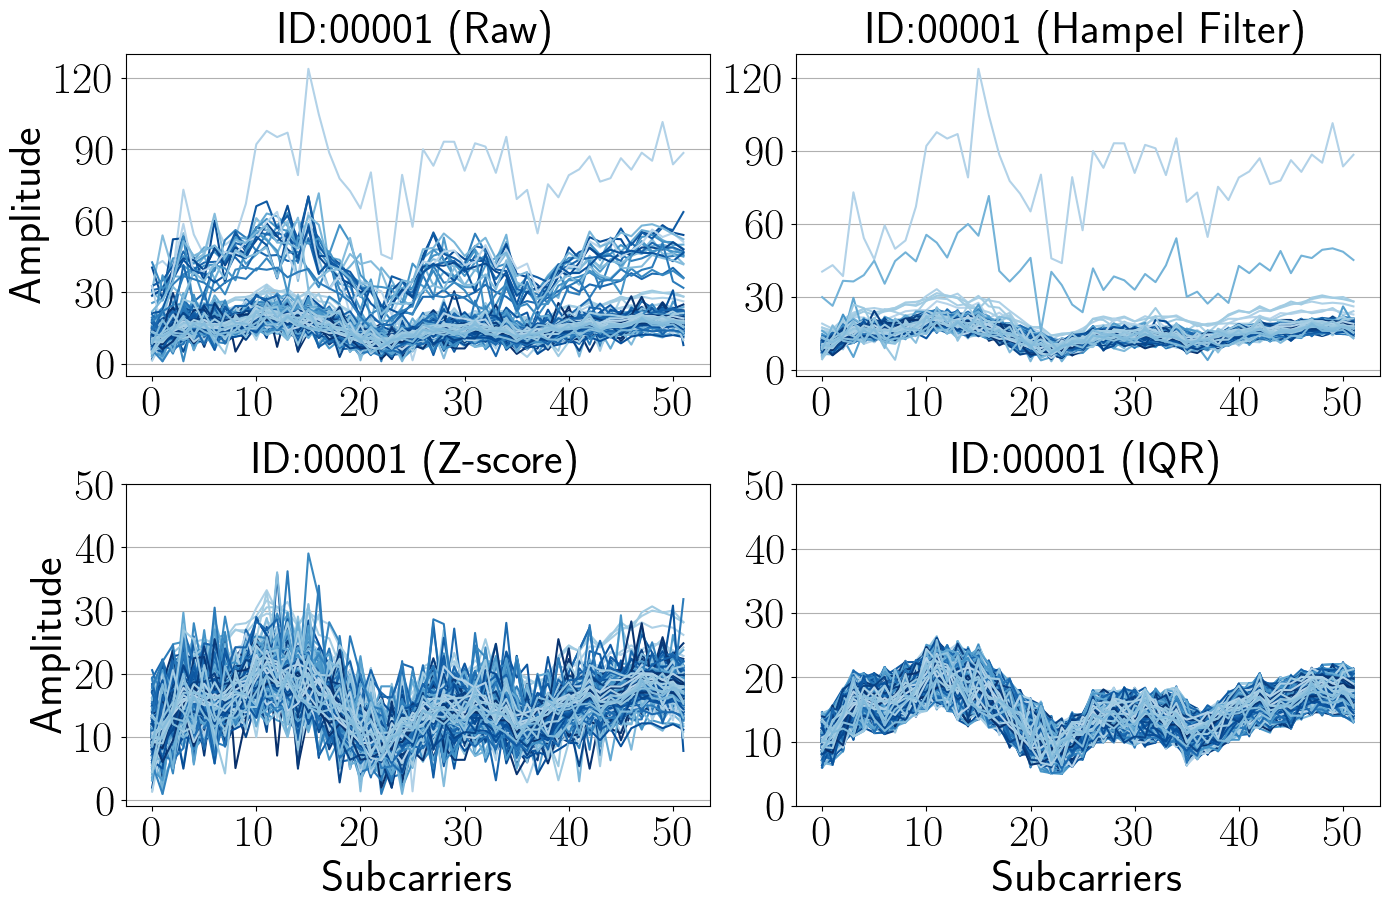

In [13]:
# Set the color cycle for the plots
color_cycle_a = cycler(color=plt.cm.Blues(np.linspace(0.3, 1, n_subcarriers)))

fig_magnitude, axes_magnitude = plt.subplots(nrows=2, ncols=2, figsize=(14, 10)) # Adjust size as needed for magnitude plots

axes_mgntd = axes_magnitude.flatten()  # Flatten the axes array for easier indexing

axes_mgntd[0].set_prop_cycle(color_cycle_a)
axes_mgntd[1].set_prop_cycle(color_cycle_a)
axes_mgntd[2].set_prop_cycle(color_cycle_a)
axes_mgntd[3].set_prop_cycle(color_cycle_a)

# Plotting amplitude for the individual
for packet in range(len(amplitudes[ID].values)):
    axes_mgntd[0].plot(np.arange(len(amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}')

axes_mgntd[0].set_title(f'ID:{ID[:-2]} (Raw)', fontsize=32)
#axes_mgntd[0].set_xlabel('Subcarriers',fontsize=26)
axes_mgntd[0].set_ylabel('Amplitude',fontsize=32)
axes_mgntd[0].set_xticks(np.arange(0, n_subcarriers, 10))
axes_mgntd[0].set_yticks(np.arange(0, 150, 30))
axes_mgntd[0].tick_params(axis='both', which='major', labelsize=32)
#axes_mean[0].legend()
axes_mgntd[0].grid(axis='y')

# Plotting amplitude (Hampel Filter) for the individual
for packet in range(len(amplitudes[ID].values)):
    axes_mgntd[1].plot(np.arange(len(hampel_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), hampel_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}')

axes_mgntd[1].set_title(f'ID:{ID[:-2]} (Hampel Filter)', fontsize=32)
#axes_mgntd[1].set_xlabel('Subcarriers', fontsize=26)
#axes_mgntd[1].set_ylabel('Amplitude', fontsize=26)
axes_mgntd[1].set_xticks(np.arange(0, n_subcarriers, 10))
axes_mgntd[1].set_yticks(np.arange(0, 150, 30))
axes_mgntd[1].tick_params(axis='both', which='major', labelsize=32)
#axes_mean[0].legend()
axes_mgntd[1].grid(axis='y')

# Plotting zscore amplitude (zscore) for the individual
for packet in range(len(amplitudes[ID].values)):
    axes_mgntd[2].plot(np.arange(len(zscore_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), zscore_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}')

axes_mgntd[2].set_title(f'ID:{ID[:-2]} (Z-score)', fontsize=32)
axes_mgntd[2].set_xlabel('Subcarriers', fontsize=32)
axes_mgntd[2].set_yticks(np.arange(0, 60, 10))
axes_mgntd[2].set_xticks(np.arange(0, n_subcarriers, 10))
axes_mgntd[2].set_ylabel('Amplitude', fontsize=32)
axes_mgntd[2].tick_params(axis='both', which='major', labelsize=32)
#axes_mean[0].legend()
axes_mgntd[2].grid(axis='y')

# Plotting amplitude (IQR) for the individual
for packet in range(len(amplitudes[ID].values)):
    axes_mgntd[3].plot(np.arange(len(iqr_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :])), iqr_amplitudes[ID].drop(columns='timestamp').applymap(float).iloc[packet, :], label=f'Subcarrier {packet}')

axes_mgntd[3].set_title(f'ID:{ID[:-2]} (IQR)', fontsize=32)
axes_mgntd[3].set_xlabel('Subcarriers', fontsize=32)
axes_mgntd[3].set_yticks(np.arange(0, 60, 10))
axes_mgntd[3].set_xticks(np.arange(0, n_subcarriers, 10))
#axes_mgntd[3].set_ylabel('Amplitude', fontsize=26)
axes_mgntd[3].tick_params(axis='both', which='major', labelsize=32)
#axes_mean[0].legend()
axes_mgntd[3].grid(axis='y')

fig_magnitude.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the rect parameters as needed

plt.show()

## Magnitude heatmaps

C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\677604517.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axes_mgntd[0].imshow(amplitudes[ID].drop(columns='timestamp').applymap(float), cmap='viridis', aspect='auto')
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\677604517.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axes_mgntd[1].imshow(hampel_amplitudes[ID].drop(columns='timestamp').applymap(float), cmap='viridis', aspect='auto')
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\677604517.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axes_mgntd[2].imshow(zscore_amplitudes[ID].drop(columns='timestamp').applymap(float), cmap='viridis', aspect='auto')
C:\Users\Marco\AppData\Local\Temp\ipykernel_16812\677604517.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axes_mgntd[3].imshow(iqr_amplitudes[ID].drop(columns

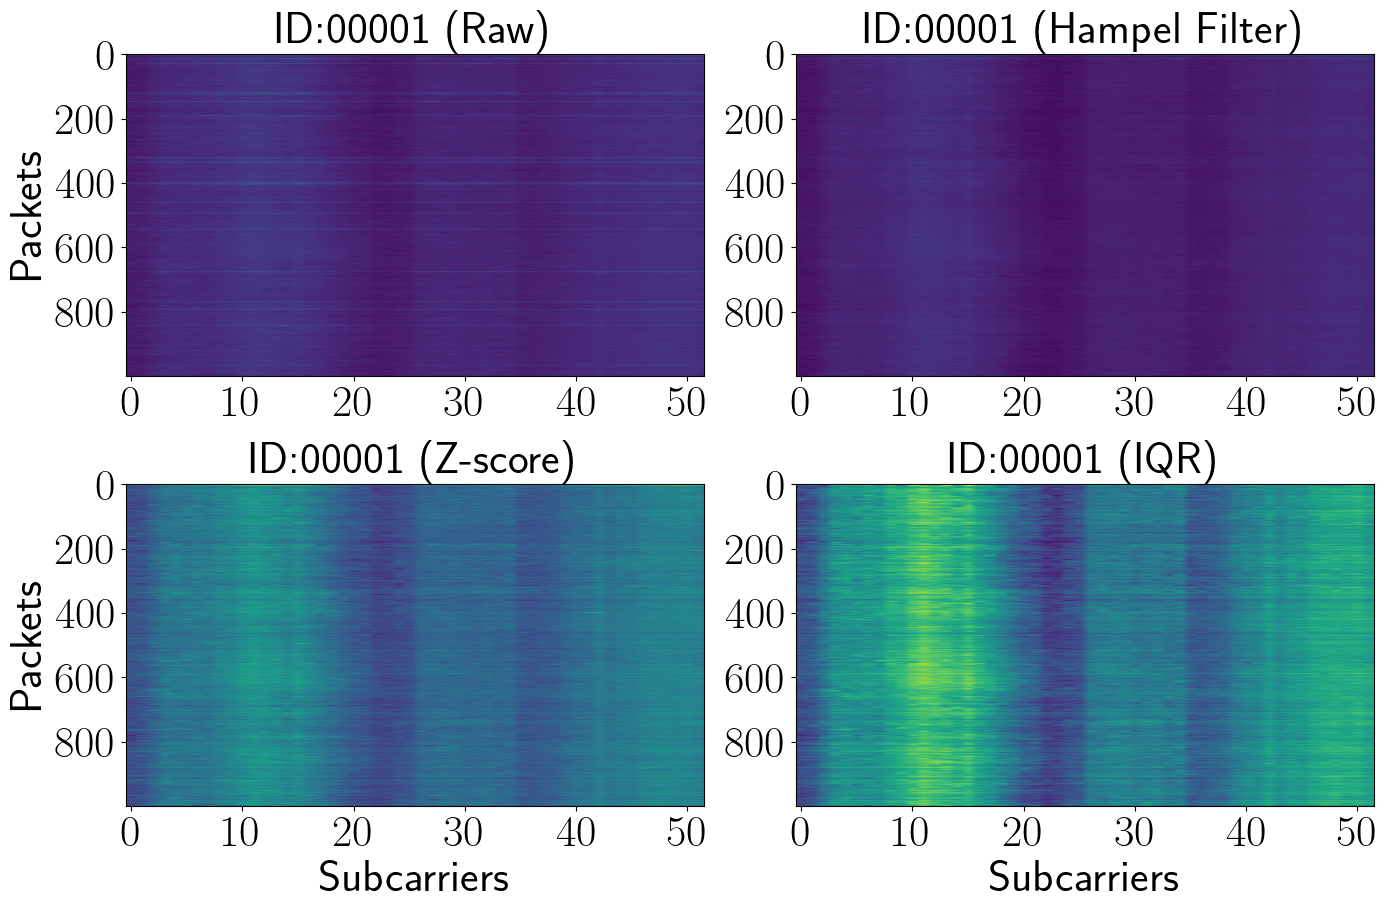

In [14]:
# Set the color cycle for the plots
color_cycle_a = cycler(color=plt.cm.Blues(np.linspace(0.3, 1, n_subcarriers)))

fig_magnitude, axes_magnitude = plt.subplots(nrows=2, ncols=2, figsize=(14, 10)) # Adjust size as needed for magnitude plots

axes_mgntd = axes_magnitude.flatten()  # Flatten the axes array for easier indexing

axes_mgntd[1].set_prop_cycle(color_cycle_a)
axes_mgntd[2].set_prop_cycle(color_cycle_a)
axes_mgntd[3].set_prop_cycle(color_cycle_a)

axes_mgntd[0].imshow(amplitudes[ID].drop(columns='timestamp').applymap(float), cmap='viridis', aspect='auto')
axes_mgntd[0].set_title(f'ID:{ID[:-2]} (Raw)', fontsize=32)
#axes_mgntd[0].set_xlabel('Subcarriers',fontsize=26)
axes_mgntd[0].set_ylabel('Packets',fontsize=32)
axes_mgntd[0].set_xticks(np.arange(0, n_subcarriers, 10))
axes_mgntd[0].set_yticks(np.arange(0, len(amplitudes[ID].drop(columns='timestamp')), 200))
axes_mgntd[0].tick_params(axis='both', which='major', labelsize=32)

# Plotting santized signal magnitude (Hampel Filter) for the individual
axes_mgntd[1].imshow(hampel_amplitudes[ID].drop(columns='timestamp').applymap(float), cmap='viridis', aspect='auto')
axes_mgntd[1].set_title(f'ID:{ID[:-2]} (Hampel Filter)', fontsize=32)
axes_mgntd[1].set_xticks(np.arange(0, n_subcarriers, 10))
axes_mgntd[1].set_yticks(np.arange(0, len(amplitudes[ID].drop(columns='timestamp')), 200))
#axes_mgntd[1].set_xlabel('Subcarriers',fontsize=26)
#axes_mgntd[1].set_ylabel('Packets',fontsize=26)
axes_mgntd[1].tick_params(axis='both', which='major', labelsize=32)

# Plotting santized signal magnitude (zscore) for the individual
axes_mgntd[2].imshow(zscore_amplitudes[ID].drop(columns='timestamp').applymap(float), cmap='viridis', aspect='auto')
axes_mgntd[2].set_title(f'ID:{ID[:-2]} (Z-score)', fontsize=32)
axes_mgntd[2].set_xlabel('Subcarriers',fontsize=32)
axes_mgntd[2].set_ylabel('Packets',fontsize=32)
axes_mgntd[2].set_xticks(np.arange(0, n_subcarriers, 10))
axes_mgntd[2].set_yticks(np.arange(0, len(amplitudes[ID].drop(columns='timestamp')), 200))
axes_mgntd[2].tick_params(axis='both', which='major', labelsize=32)

# Plotting santized signal magnitude (IQR) for the individual
axes_mgntd[3].imshow(iqr_amplitudes[ID].drop(columns='timestamp').applymap(float), cmap='viridis', aspect='auto')
axes_mgntd[3].set_title(f'ID:{ID[:-2]} (IQR)', fontsize=32)
axes_mgntd[3].set_xlabel('Subcarriers',fontsize=32)
axes_mgntd[3].set_xticks(np.arange(0, n_subcarriers, 10))
axes_mgntd[3].set_yticks(np.arange(0, len(amplitudes[ID].drop(columns='timestamp')), 200))
#axes_mgntd[3].set_ylabel('Packets',fontsize=26)
axes_mgntd[3].tick_params(axis='both', which='major', labelsize=32)

fig_magnitude.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the rect parameters as needed

plt.show()